# Setup

In [1]:
%matplotlib inline
import os, sys, glob, shutil
from matplotlib import pyplot as plt
import numpy as np
import torch
import h5py
from sklearn import metrics
from scipy.stats import special_ortho_group
from scipy.optimize import curve_fit
from IPython.display import Image
sys.path.append('../utils/')
import functions_for_fred as fn
import nn
import viz
import pred

In [2]:
fig_force_update_master=False

In [3]:
CLASS_NUMBER = 39
L            = 4
EPOCH_NUMBER = 160
CHECKPTH_KEY = 'cone_'
DATA_KEY     = 'class_2d_{}'.format(CLASS_NUMBER)
METADATA_KEY = 'class2D'

In [4]:
# no need to edit this cell
KEYWORD      = 'cryo_exp_{}_128x128'.format(DATA_KEY)
CHECKPT_FILE = 'cryo_exp_{}_l{}_{}epoch_{}_checkpoint.pth'.format(DATA_KEY,L,CHECKPTH_KEY,EPOCH_NUMBER)
DATASET_DIR     = '../train_val_datasets/'
METADATASET_DIR = '../datasets/exp/20181005-rib-TEM4/Sort/'
TRAINED_DIR     = '../train_vae/'
TRAIN_DATASET_PATH     = DATASET_DIR+KEYWORD+'.npy'
TRAIN_METADATASET_PATH = METADATASET_DIR+'{}_{}_sort.h5'.format(METADATA_KEY,CLASS_NUMBER)
TRAINED_CHECKPOINT     = 'epoch_'+str(EPOCH_NUMBER)+'_checkpoint.pth'
#
print('> Storing results in {}'.format(KEYWORD))
if not os.path.exists(KEYWORD):
    os.makedirs(KEYWORD)
if not os.path.exists(KEYWORD+'/train_vae'):
    os.makedirs(KEYWORD+'/train_vae')
if not os.path.isfile(KEYWORD+'/train_vae/'+TRAINED_CHECKPOINT):
    shutil.copyfile(TRAINED_DIR+CHECKPT_FILE, KEYWORD+'/train_vae/'+TRAINED_CHECKPOINT)
else:
    print('no need to copy {} again. Already found in {}/train_vae ...'.format(TRAINED_CHECKPOINT, KEYWORD))

> Storing results in cryo_exp_class_2d_39_128x128
no need to copy epoch_160_checkpoint.pth again. Already found in cryo_exp_class_2d_39_128x128/train_vae ...


# Load dataset, encoder and decoder

In [5]:
# this is juste convenient
fig_force_update=False
if fig_force_update_master:
    fig_force_update=True

dataset.shape (5119, 1, 128, 128) metadata.shape (5119, 180, 180)


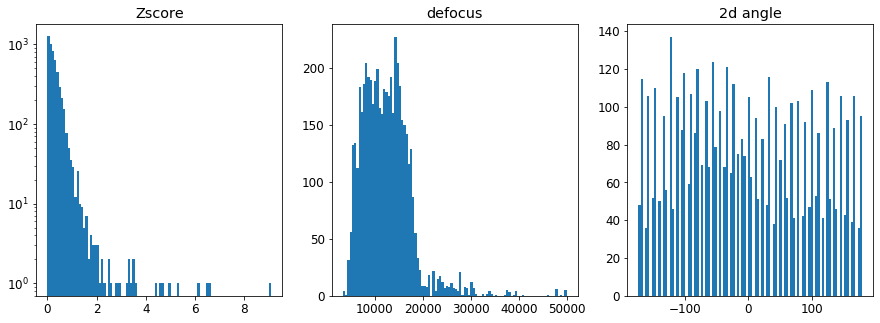

In [72]:
dataset = np.load(TRAIN_DATASET_PATH)
metadata = h5py.File(TRAIN_METADATASET_PATH, 'r')
#
Zscore       = np.array(metadata['_rlnparticleselectzscore'])
defocus_true = np.array(metadata['_rlndefocusu'])
angle_true   = np.array(metadata['_rlnanglepsi'])
tx_true      = np.array(metadata['_rlnoriginx'])
ty_true      = np.array(metadata['_rlnoriginy'])
print('dataset.shape {} metadata.shape {}'.format(dataset.shape, metadata['particles'].shape))
#
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Zscore')
plt.hist(Zscore, bins=100, log=True)
plt.subplot(1,3,2)
plt.title('defocus')
plt.hist(defocus_true, bins=100, log=False)
plt.subplot(1,3,3)
plt.title('2d angle')
plt.hist(angle_true, bins=100, log=False)
fig.savefig(KEYWORD+'/data.png')

In [7]:
mus = []
mus = fn.latent_projection(KEYWORD, TRAIN_DATASET_PATH, epoch_id=EPOCH_NUMBER)
mus.shape

cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth
Found checkpoint. Getting: cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth.
Loading encoder from network of architecture: conv_orig...


(5119, 4)

In [ ]:
recon = []
recon = fn.reconstruction(KEYWORD, torch.Tensor(mus[0:500,...]).cuda(), epoch_id=EPOCH_NUMBER)
recon.shape

# Figures 

## Parameters

In [8]:
Zscore_set        = 2
measure_threshold = 0.5
methods     =['robust_covar', 'isolation_forest', 'local_outlier_detection']
method_best = methods[1]

## Define quantities

AUC(robust_covar) = 0.8100467448004878 / offset=3
AUC(isolation_forest) = 0.8522932050674074 / offset=0.5
AUC(local_outlier_detection) = 0.8163471309531873 / offset=1.5
True positives: 5090 | True negatives: 29
Predicted positives: 4293 | Predicted negatives: 826
Curated dataset size: 4140


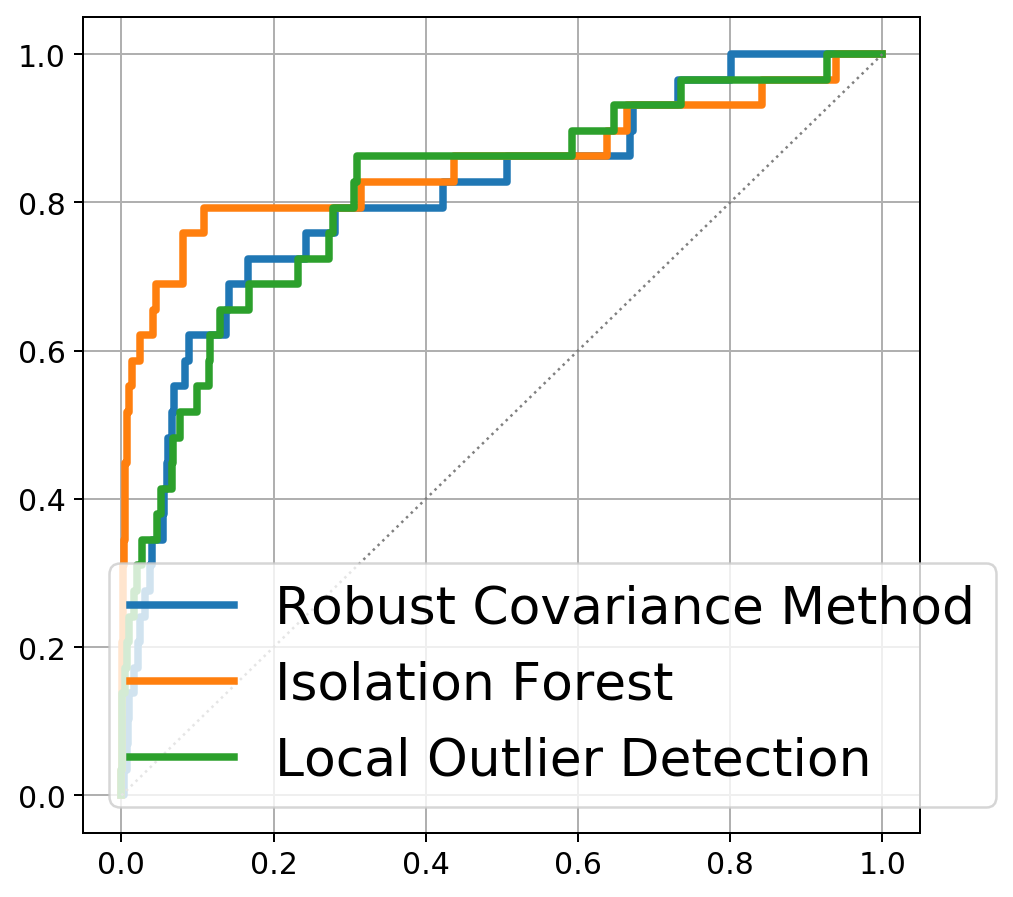

In [73]:
viz.plot_roc_curve(mus, Zscore, Zscore_set,
                   xlabel='',ylabel='',
                   figname=KEYWORD+'/ROC_Zscore'+str(Zscore_set))
measure, offset, assignment = pred.outlier_measure(mus, method=method_best)
index_kept = np.where(measure<measure_threshold,0,1)
#
positives = np.where(Zscore<Zscore_set)[0]
negatives = np.where(Zscore>Zscore_set)[0]
print('True positives: {} | True negatives: {}'.format(positives.shape[0],negatives.shape[0]))
mus_outlier     = mus[index_kept==1,:]
defocus_outlier = defocus_true[index_kept==1]
angle_outlier   = angle_true[index_kept==1]
Zscore_outlier  = Zscore[index_kept==1]
mus_kept     = mus[index_kept==0,:]
defocus_kept = defocus_true[index_kept==0]
angle_kept   = angle_true[index_kept==0]
tx_kept = tx_true[index_kept==0]
ty_kept = ty_true[index_kept==0]
Zscore_kept  = Zscore[index_kept==0]
measure_kept = measure[index_kept==0]
print('Predicted positives: {} | Predicted negatives: {}'.format(mus_kept.shape[0],mus_outlier.shape[0]))
index_curated = np.where((defocus_kept>5000)  & (defocus_kept < 25000))[0]
mus_curated     = mus_kept[index_curated,:]
angle_curated   = angle_kept[index_curated]
tx_curated = tx_kept[index_curated]
ty_curated = ty_kept[index_curated]
defocus_curated = defocus_kept[index_curated]
Zscore_curated  = Zscore_kept[index_curated]
measure_curated = measure_kept[index_curated]
print('Curated dataset size: {}'.format(mus_curated.shape[0]))
U_curated, L_curated, Vt_curated = np.linalg.svd(mus_curated - np.mean(mus_curated,axis=0), full_matrices=False)

## raw and curated data

In [ ]:
figname=KEYWORD+'/latent_space_raw_and_curated.png'
#
run_cell=True
if run_cell:
    viz.biplots(mus_curated, prj2=mus,
                n=4, nbins=100,
                c=measure_curated, 
                c2=np.where(Zscore>2,2,Zscore), #c2map='twilight',
                show_histo=False,
                minortick=np.std(mus_curated[:,0])/2,
                majortick=np.std(mus_curated[:,0]),
                figname=figname,
                colorbar_size=500
               )
else:
    Image(figname)

## PCA

In [ ]:
figname=KEYWORD+'/pca_curated.png'
#
run_cell=True
X = np.dot(U_curated,np.diag(L_curated))
if run_cell:
    viz.biplots(X, prj2=X,
                n=4, nbins=100,
                c=defocus_curated, 
                c2=angle_curated, c2map='twilight',
                show_histo=False,
                minortick=np.std(X[:,0])/2,
                majortick=np.std(X[:,0]),
                figname=figname,
                colorbar_size=500
               )
else:
    Image(figname)

## Representative True positive, etc.

In [ ]:
index_positive = np.where(Zscore<Zscore_set)[0]
index_negative = np.where(Zscore>Zscore_set)[0]
#
index_true_positive  = np.intersect1d(index_positive, np.where(index_kept==0))
index_false_positive = np.intersect1d(index_negative, np.where(index_kept==0))
index_true_negative  = np.intersect1d(index_negative, np.where(index_kept==1))
index_false_negative = np.intersect1d(index_positive, np.where(index_kept==1))
print('TP:{} FP:{} TN:{} FN:{}'.format(index_true_positive .shape[0], 
                           index_false_positive.shape[0], 
                           index_true_negative.shape[0],
                           index_false_negative.shape[0]
                          )
     )
particle_images = np.array(metadata['particles'])

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(np.mean(particle_images[index_false_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,2)
plt.imshow(np.mean(particle_images[index_true_positive[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,3)
plt.imshow(np.mean(particle_images[index_true_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,4)
plt.imshow(np.mean(particle_images[index_false_positive[0:6],...],axis=0), cmap='Greys_r')

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(np.std(particle_images[index_false_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,2)
plt.imshow(np.std(particle_images[index_true_positive[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,3)
plt.imshow(np.std(particle_images[index_true_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,4)
plt.imshow(np.std(particle_images[index_false_positive[0:6],...],axis=0), cmap='Greys_r')

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_positive[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_negative[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_positive[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_negative[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in np.arange(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_negative[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in np.arange(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_positive[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(18):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_negative[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_true_negatives.png')

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(18):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_positive[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_true_positives.png')

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(18):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_negative[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_false_negatives.png')

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(6):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_positive[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_false_positives.png')

## giffy

In [ ]:
recon = []
recon = fn.reconstruction(KEYWORD, torch.Tensor(mus_curated[0:500,...]).cuda(), epoch_id=EPOCH_NUMBER)
recon.shape

In [ ]:
index_curated = np.where(index_kept==0)[0]
index_curated.shape
angle_curated[0:500].shape
index_ordered = np.argsort(angle_curated[0:500])

In [ ]:
plt.hist(angle_curated[index_ordered[np.arange(0,500,10)]], bins=100)
plt.show()

In [ ]:
r, theta = pred.cart2pol(U_curated[0:500,0], U_curated[0:500,1])
plt.hist(r)

In [ ]:
index_theta_ordered = np.argsort(theta)
index_r_shell       = np.where((r>0.027) & (r<0.03))[0]
theta_sorted, index_gif, index_r = np.intersect1d(index_theta_ordered, index_r_shell, return_indices=True)
#
fig = plt.figure
plt.subplot(2,2,1)
plt.plot(index_theta_ordered)
plt.subplot(2,2,2)
plt.plot(index_r_shell)
plt.subplot(2,2,3)
plt.plot(index_theta_ordered[index_gif])
plt.subplot(2,2,4)
plt.plot(index_r_shell[index_r])
plt.show()
#
fig = plt.figure()
plt.plot(theta[index_theta_ordered])
plt.plot(index_gif,theta[index_theta_ordered[index_gif]], 'X')
plt.show()
#for i in np.arange(index_gif.shape[0]):   
#    print('{:03d} {:03d} {:.02f}'.format(index_gif[i], index_theta_ordered[index_gif[i]], theta[index_theta_ordered[index_gif[i]]]))
for i in np.argsort(index_gif):

    print('{:03d} {:03d} {:.02f}'.format(index_gif[i], index_theta_ordered[index_gif[i]], theta[index_theta_ordered[index_gif[i]]]))

In [ ]:
j=11
if(np.mod(j,12)==0):
    print(j)

In [ ]:
def visualize_simple(dataset, reconstruction,
              crds1, crds2,
              metadata1, metadata2,
              iframe=0, markersize=12,
              cmap1=None, cmap2=None,
              show_3dpsd=True, show_1dpsd=True,
              figname=''):
    """
    """
    font = {'family' : 'monospace',
            'weight' : 'bold',
            'size'   : 12}
    plt.rc('font', **font)
    ### SETUP
    width= 6
    height = 6
    n_row=2
    n_col=2
    data_image     = dataset[iframe,0,...]
    reconstructed = reconstruction[iframe,0,...]
    ### START FIGURE 
    fig = plt.figure(figsize=(width,height), dpi=180)
    #
    plt.subplot(n_row,n_col,1)
    plt.title('Angle-colored\n Latent Space')
    plt.scatter(crds1[:,0], crds1[:,1], c=metadata1, cmap=cmap1, marker='.', linewidth=1)
    plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False, 
                left=False, # ticks along the top edge are off
                labelleft=False,
                labelbottom=False) # labels along the bottom edge ar
    plt.plot(crds1[iframe,0], crds1[iframe,1], color='black', marker='o', markersize=markersize)
    #plt.grid()
    #cbar = plt.colorbar(orientation='horizontal')
    #cbar.set_ticks([-90,90])
    #cbar.set_label('angle (degrees)')
    plt.subplot(n_row,n_col,2)
    plt.title('Defocus-colored\n  Latent Space')
    plt.scatter(crds2[:,0], crds2[:,1], c=metadata2, cmap=cmap2, marker='.', linewidth=1)
    plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False, 
                left=False, # ticks along the top edge are off
                labelleft=False,
                labelbottom=False) # labels along the bottom edge ar
    plt.plot(crds2[iframe,0], crds2[iframe,1], color='black', marker='o', markersize=markersize)
    #plt.grid()
    #cbar = plt.colorbar(orientation='horizontal')
    #cbar.set_ticks([1.0,2.0])
    #cbar.set_label('defocus (um)')
    #
    plt.subplot(n_row,n_col,3)
    plt.title('Particle')
    plt.imshow(data_image,cmap='Greys_r')
    plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False, 
                left=False, # ticks along the top edge are off
                labelleft=False,
                labelbottom=False) # labels along the bottom edge ar
    plt.subplot(n_row,n_col,4)
    plt.title('Reconstruction')
    plt.imshow(reconstructed,cmap='Greys_r')
    plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False, 
                left=False, # ticks along the top edge are off
                labelleft=False,
                labelbottom=False) # labels along the bottom edge ar
    plt.show()
    plt.tight_layout()
    if(figname):
        fig.savefig(figname)


In [ ]:
visualize_simple(np.expand_dims(particle_images,axis=1)[index_curated[0:500],...],
              recon,
              U_curated[:,0:2], U_curated[:,0:2],
              angle_curated, np.where(defocus_curated>25000,25000,defocus_curated)/1e4,
              iframe=index_theta_ordered[index_gif[0]],
              cmap1='twilight',
              show_1dpsd=False, show_3dpsd=False)#,

In [ ]:
viz.visualize_simple(np.expand_dims(particle_images,axis=1)[index_curated[0:500],...],
              recon,
              U_curated[:,0:2], U_curated[:,0:2],
              angle_curated, defocus_curated,
              iframe=index_theta_ordered[index_gif[0]],
              cmap1='twilight',
              show_1dpsd=False, show_3dpsd=False)#,
              #figname=KEYWORD+'/gif/gif1/rotate_{:03d}.png'.format(jcnt))

In [ ]:
j=0
jcnt=0
for i in np.argsort(index_gif): #np.arange(index_r_shell.shape[0]):
    if(np.mod(j,2)==0):
        jcnt+=1
        print(i,  theta[index_theta_ordered[index_gif[i]]])
        visualize_simple(np.expand_dims(particle_images,axis=1)[index_curated[0:500],...],
                      recon,
                      U_curated[:,0:2], U_curated[:,0:2],
                      angle_curated, defocus_curated,
                      iframe=index_theta_ordered[index_gif[i]],
                      cmap1='twilight',
                      show_1dpsd=False, show_3dpsd=False,
                      figname=KEYWORD+'/gif/gif1/rotate_{:03d}.png'.format(jcnt))
    j+=1

In [ ]:
fig = plt.figure(figsize=(12,36), dpi=180)
for i in np.arange(0,12,2):
    plt.subplot(6,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recon[i,0,...], cmap='Greys_r')
    plt.subplot(6,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_curated[i],...], cmap='Greys_r')
plt.tight_layout()
#fig.savefig(KEYWORD+'/particles_false_negatives.png')

## in-plane rotation correction

In [25]:
list(metadata.keys())

['_rlnamplitudecontrast',
 '_rlnanglepsi',
 '_rlnanglerot',
 '_rlnangletilt',
 '_rlnautopickfigureofmerit',
 '_rlnclassnumber',
 '_rlncoordinatex',
 '_rlncoordinatey',
 '_rlnctfbfactor',
 '_rlnctffigureofmerit',
 '_rlnctfmaxresolution',
 '_rlnctfscalefactor',
 '_rlndefocusangle',
 '_rlndefocusu',
 '_rlndefocusv',
 '_rlndetectorpixelsize',
 '_rlngroupnumber',
 '_rlnimagename',
 '_rlnloglikelicontribution',
 '_rlnmagnification',
 '_rlnmaxvalueprobdistribution',
 '_rlnmicrographname',
 '_rlnnormcorrection',
 '_rlnnrofsignificantsamples',
 '_rlnoriginx',
 '_rlnoriginy',
 '_rlnparticleselectzscore',
 '_rlnphaseshift',
 '_rlnsphericalaberration',
 '_rlnvoltage',
 'particles']

In [13]:
particle_images = np.array(metadata['particles'])

In [87]:
recon = []
recon = fn.reconstruction(KEYWORD, torch.Tensor(mus_curated[0:1000,...]).cuda(), epoch_id=EPOCH_NUMBER)
recon.shape

cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth
Found checkpoint. Getting: cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth.
Loading decoder from network of architecture: conv_orig...


(1000, 1, 128, 128)

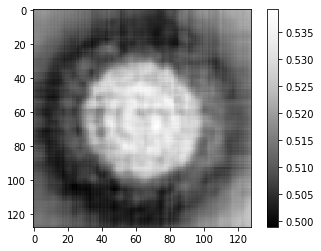

In [11]:
plt.imshow(np.mean(recon[0:500,0,...],axis=0), cmap='Greys_r')
plt.colorbar()

In [15]:
particles_dataset = np.expand_dims(particle_images,axis=1)[index_curated[0:1000],...]
particles_dataset.shape

(1000, 1, 180, 180)

In [88]:
from scipy.ndimage import rotate
recon_rot = np.zeros(recon.shape)
particles_rot = np.zeros(particles_dataset.shape)
for i in np.arange(1000):
    #print(i,angle_curated[i])
    recon_rot[i,0,:,:] = rotate(recon[i,0,:,:],angle=-angle_curated[i],axes=(0,1),mode='wrap', reshape=False) 
    particles_rot[i,0,:,:] = rotate(particles_dataset[i,0,:,:],angle=-angle_curated[i],axes=(0,1), mode='wrap', reshape=False) 

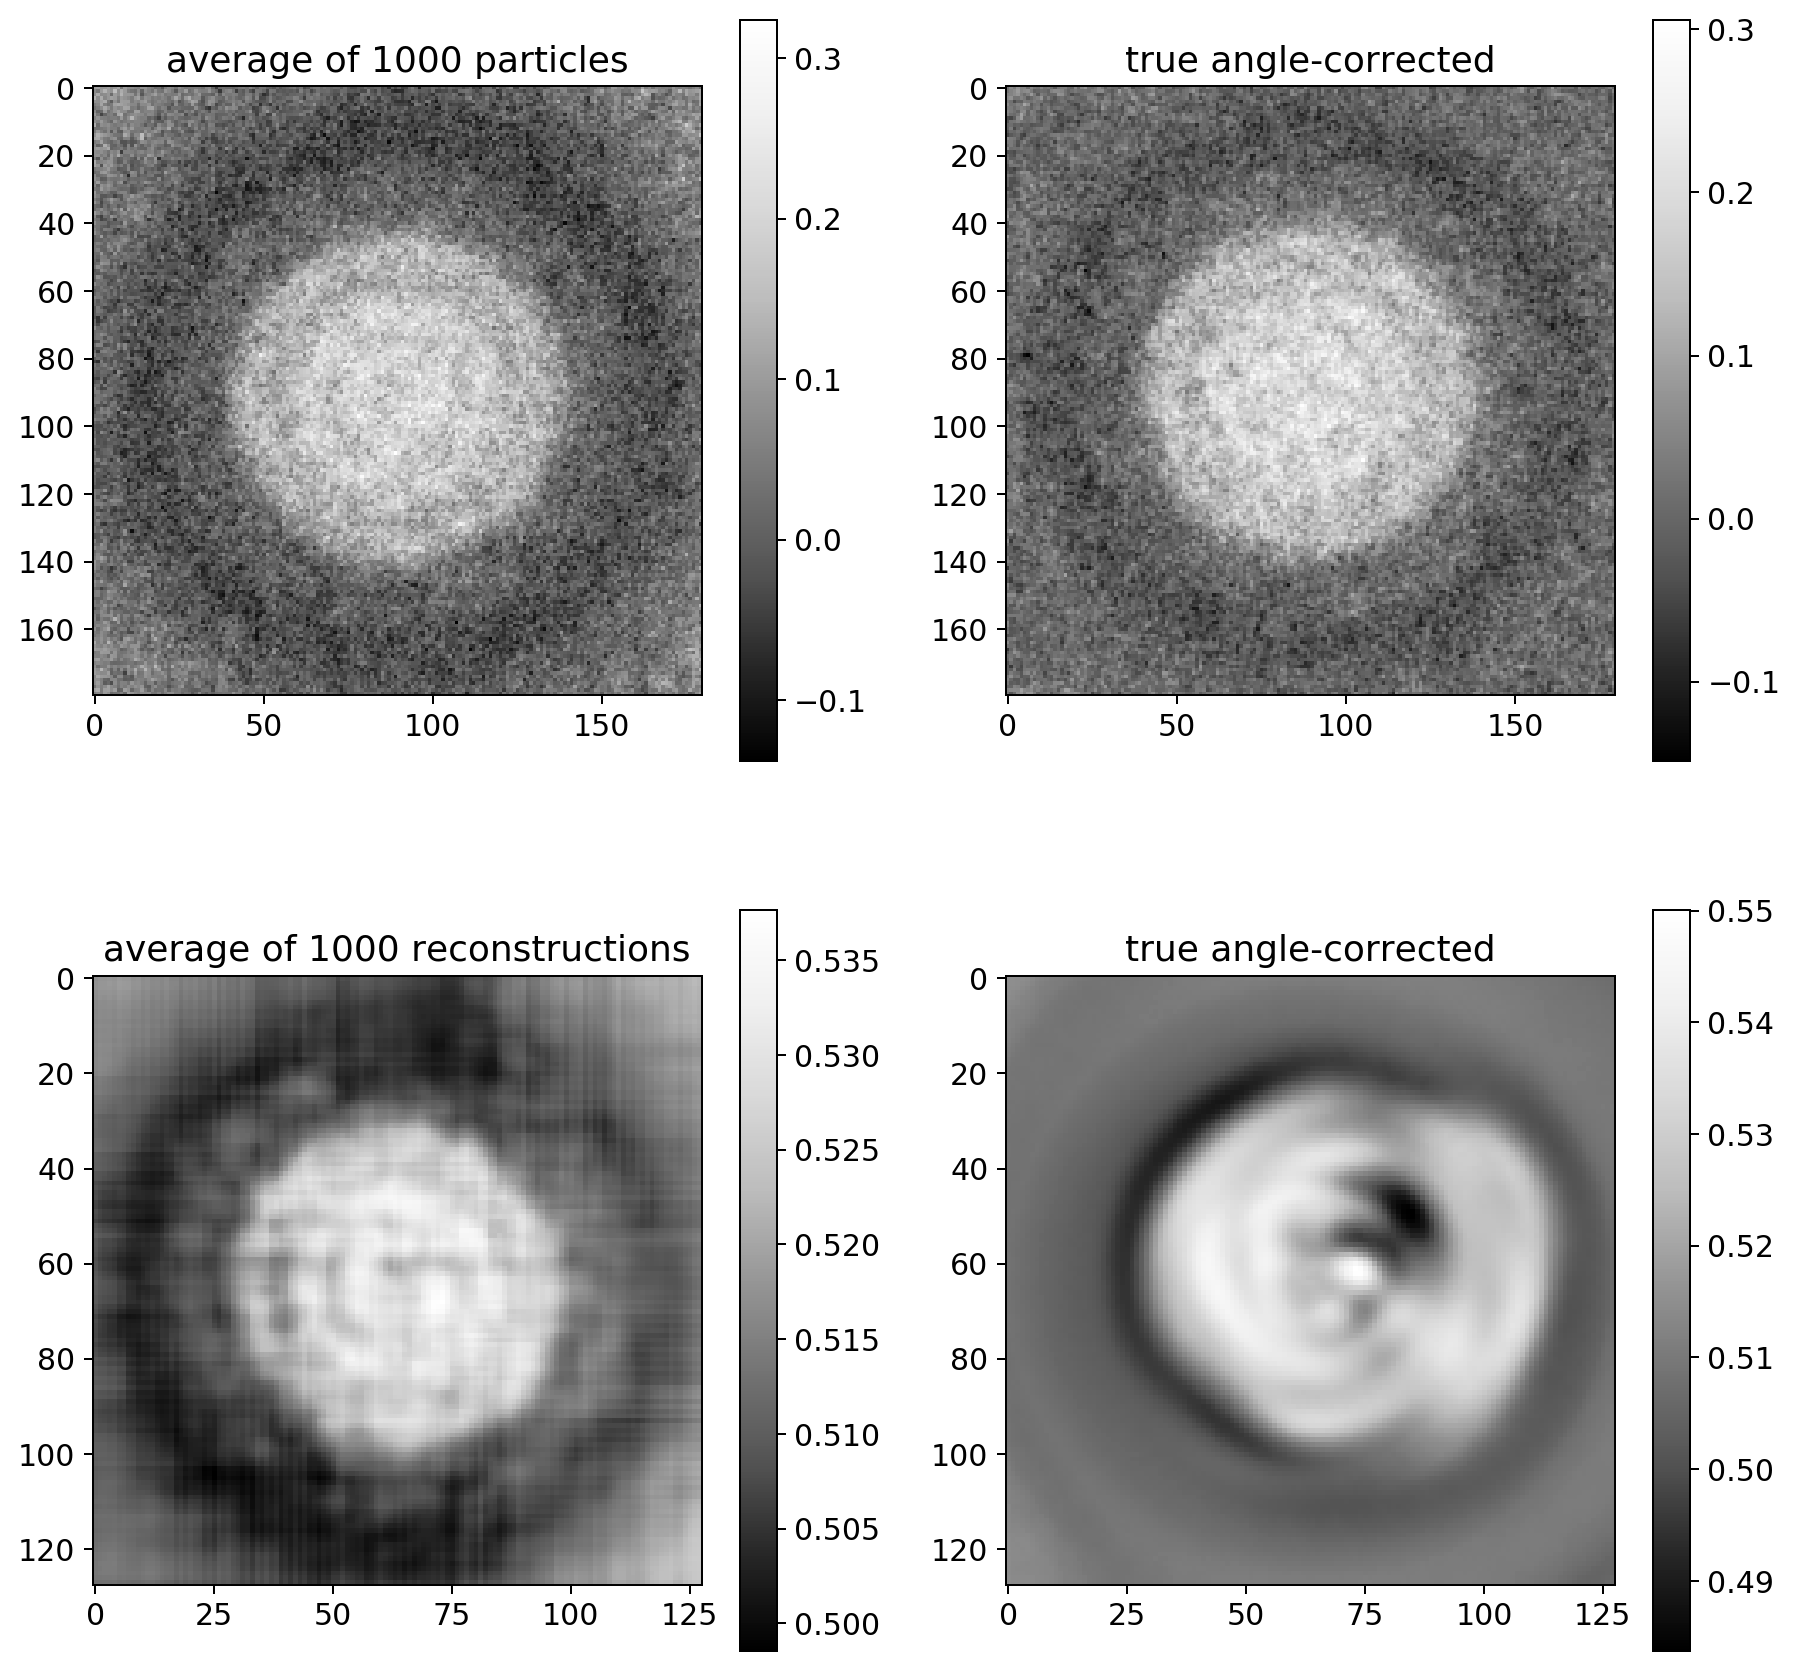

In [89]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true angle-corrected')
plt.imshow(np.mean(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true angle-corrected')
plt.imshow(np.mean(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

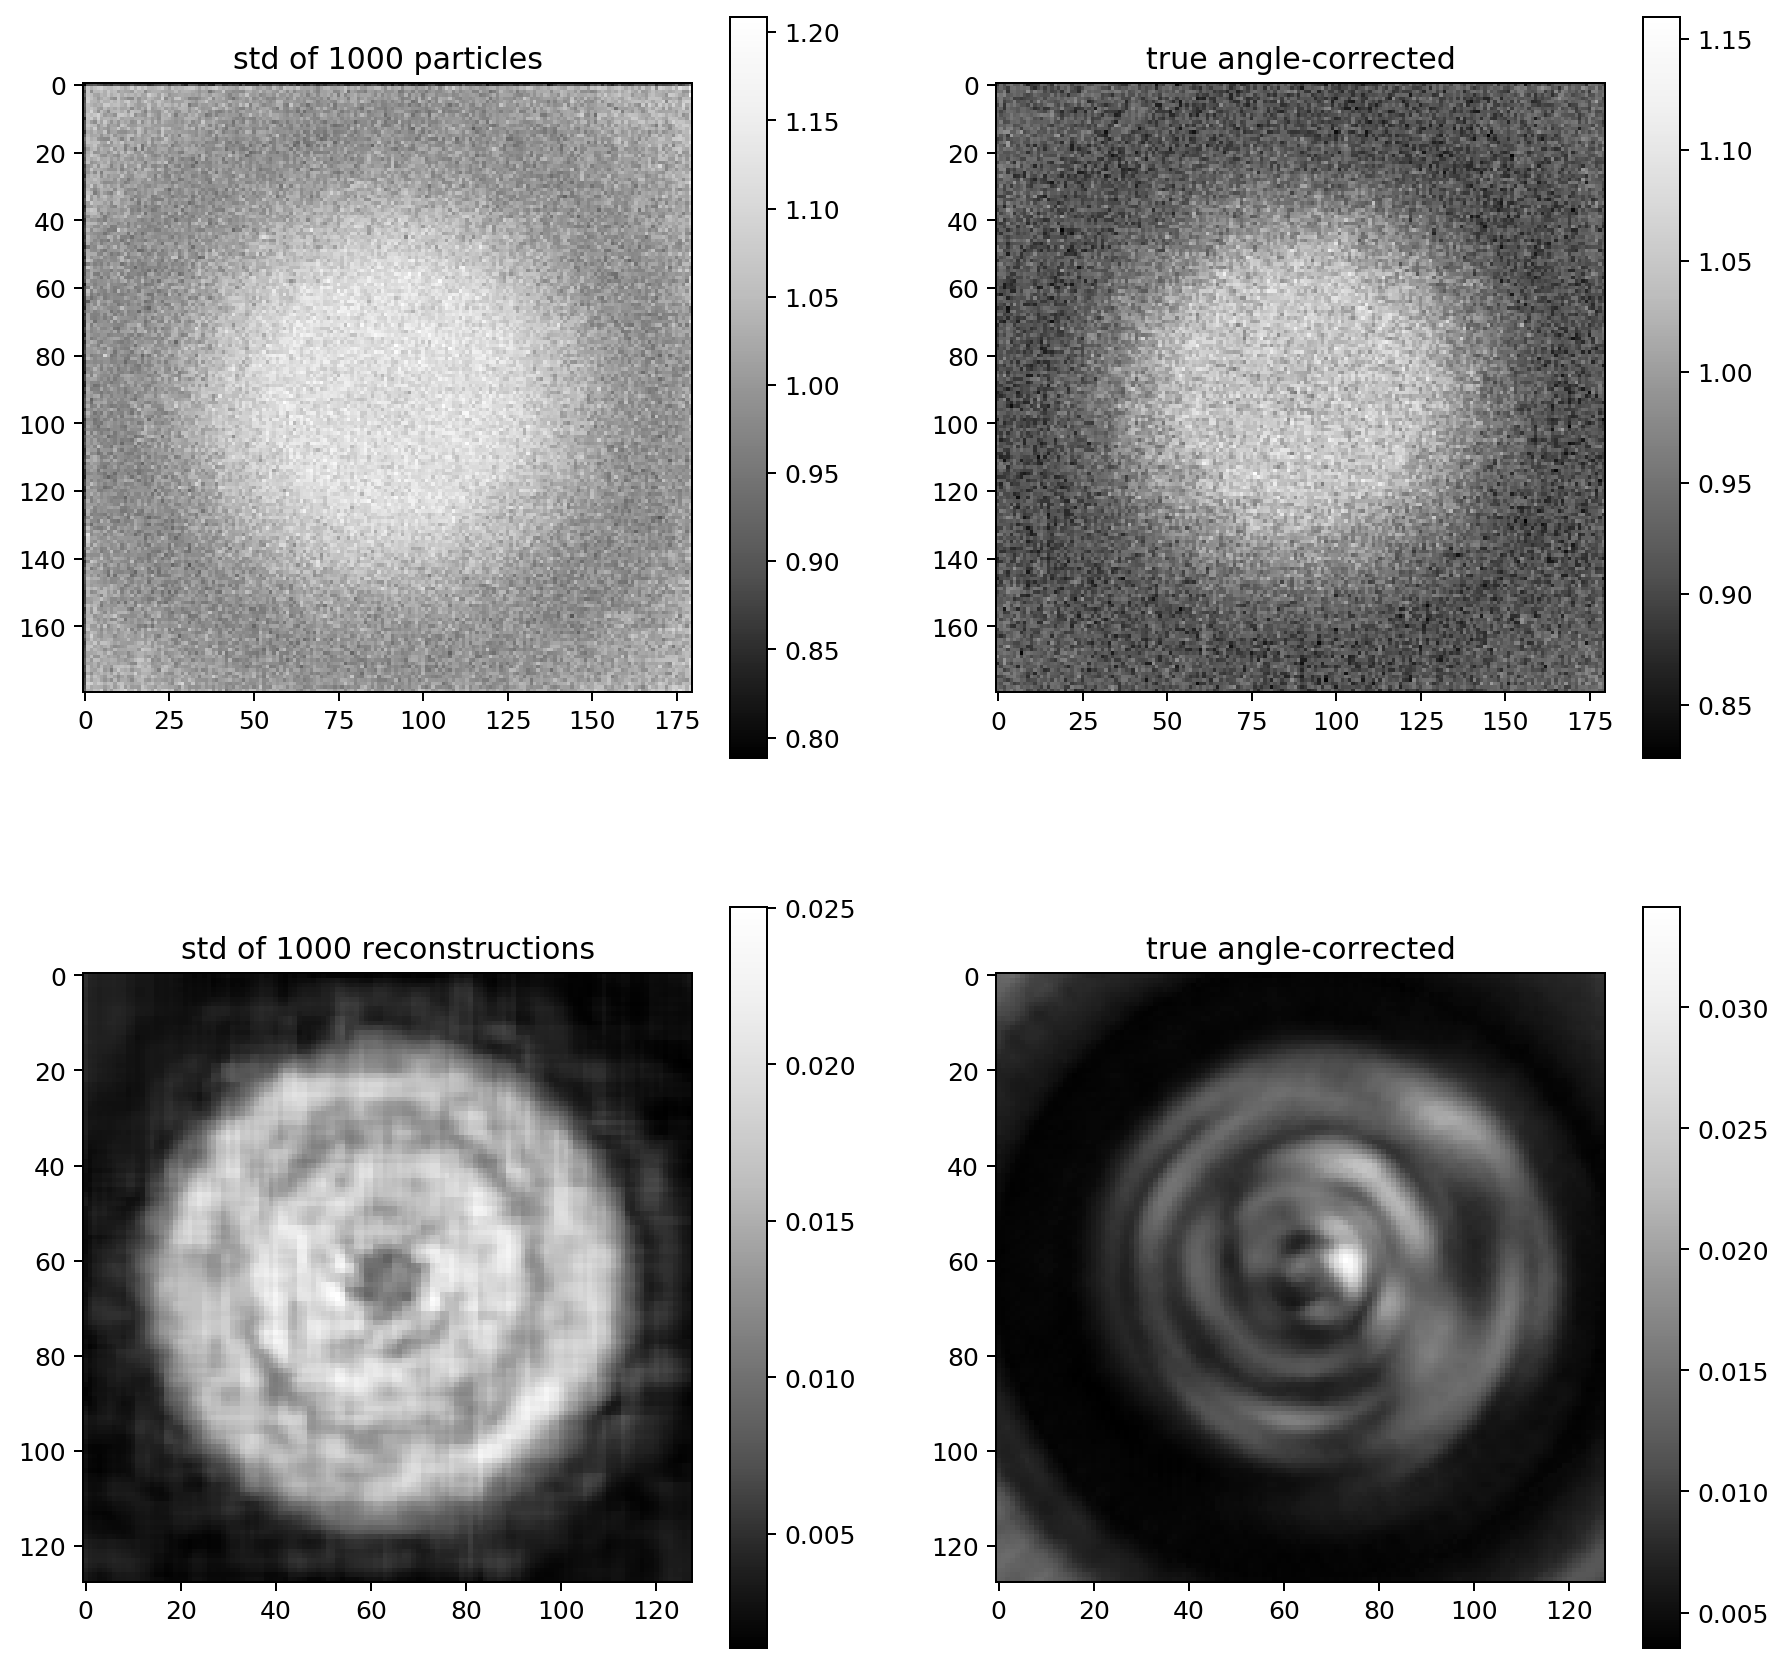

In [22]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('std of 1000 particles')
plt.imshow(np.std(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true angle-corrected')
plt.imshow(np.std(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('std of 1000 reconstructions')
plt.imshow(np.std(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true angle-corrected')
plt.imshow(np.std(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

In [42]:
from scipy.ndimage import rotate
recon_rot = np.zeros(recon.shape)
particles_rot = np.zeros(particles_dataset.shape)
for i in np.arange(1000):
    #print(i,angle_curated[i])
    recon_rot[i,0,:,:] = rotate(recon[i,0,:,:],angle=-angle_pred[i],axes=(0,1),mode='wrap', reshape=False) 
    particles_rot[i,0,:,:] = rotate(particles_dataset[i,0,:,:],angle=-angle_pred[i],axes=(0,1), mode='wrap', reshape=False) 

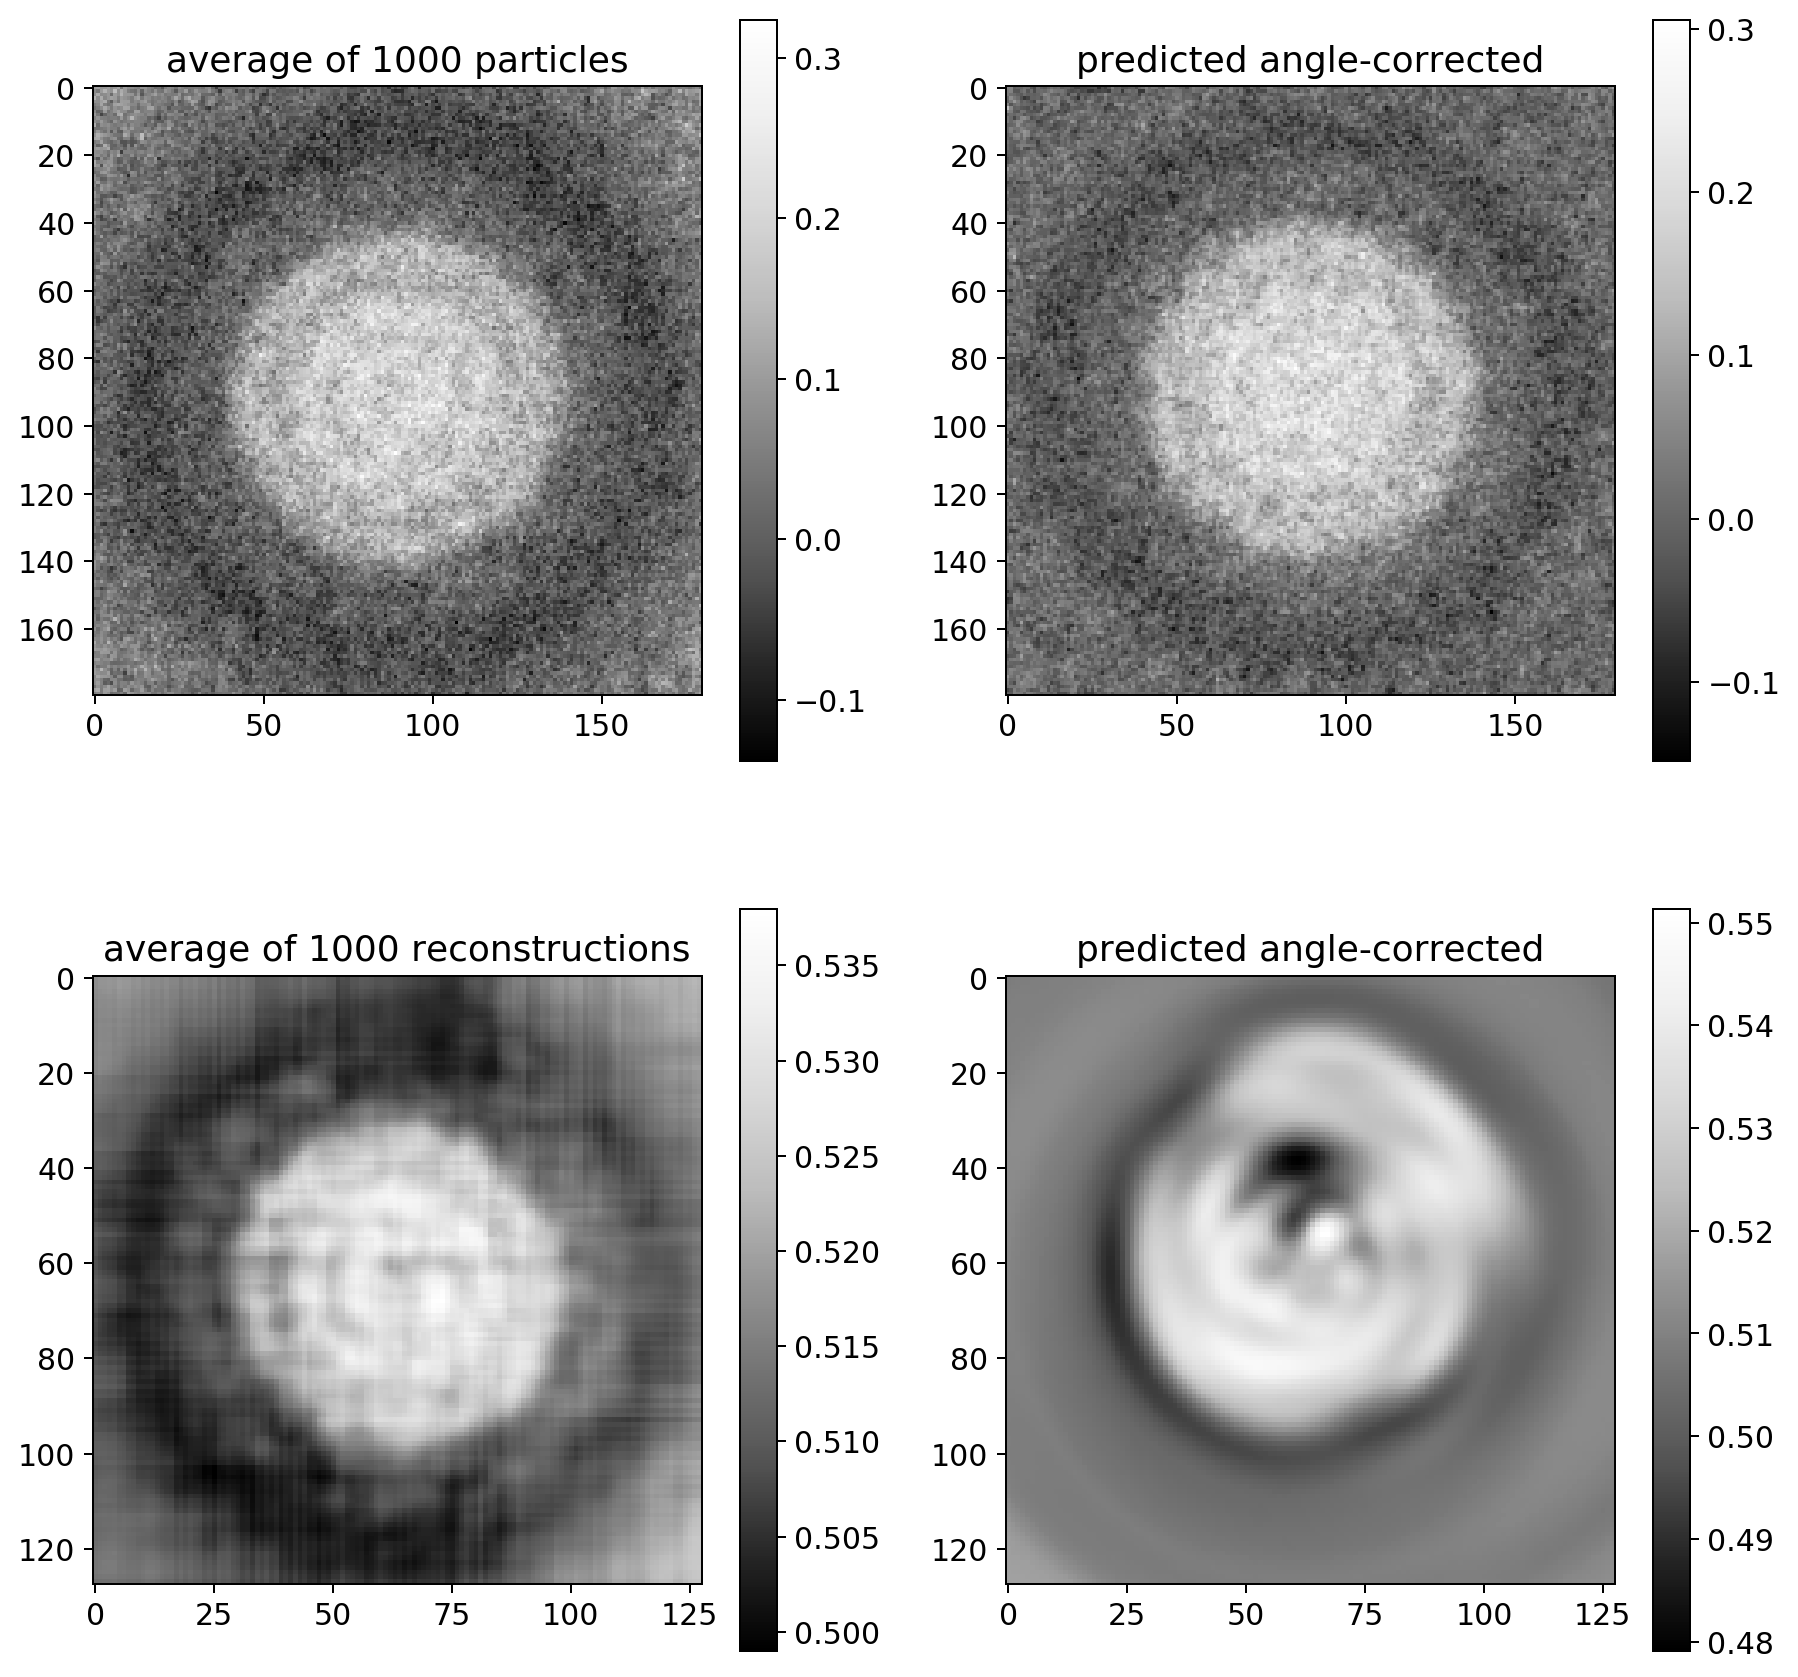

In [44]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('predicted angle-corrected')
plt.imshow(np.mean(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('predicted angle-corrected')
plt.imshow(np.mean(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

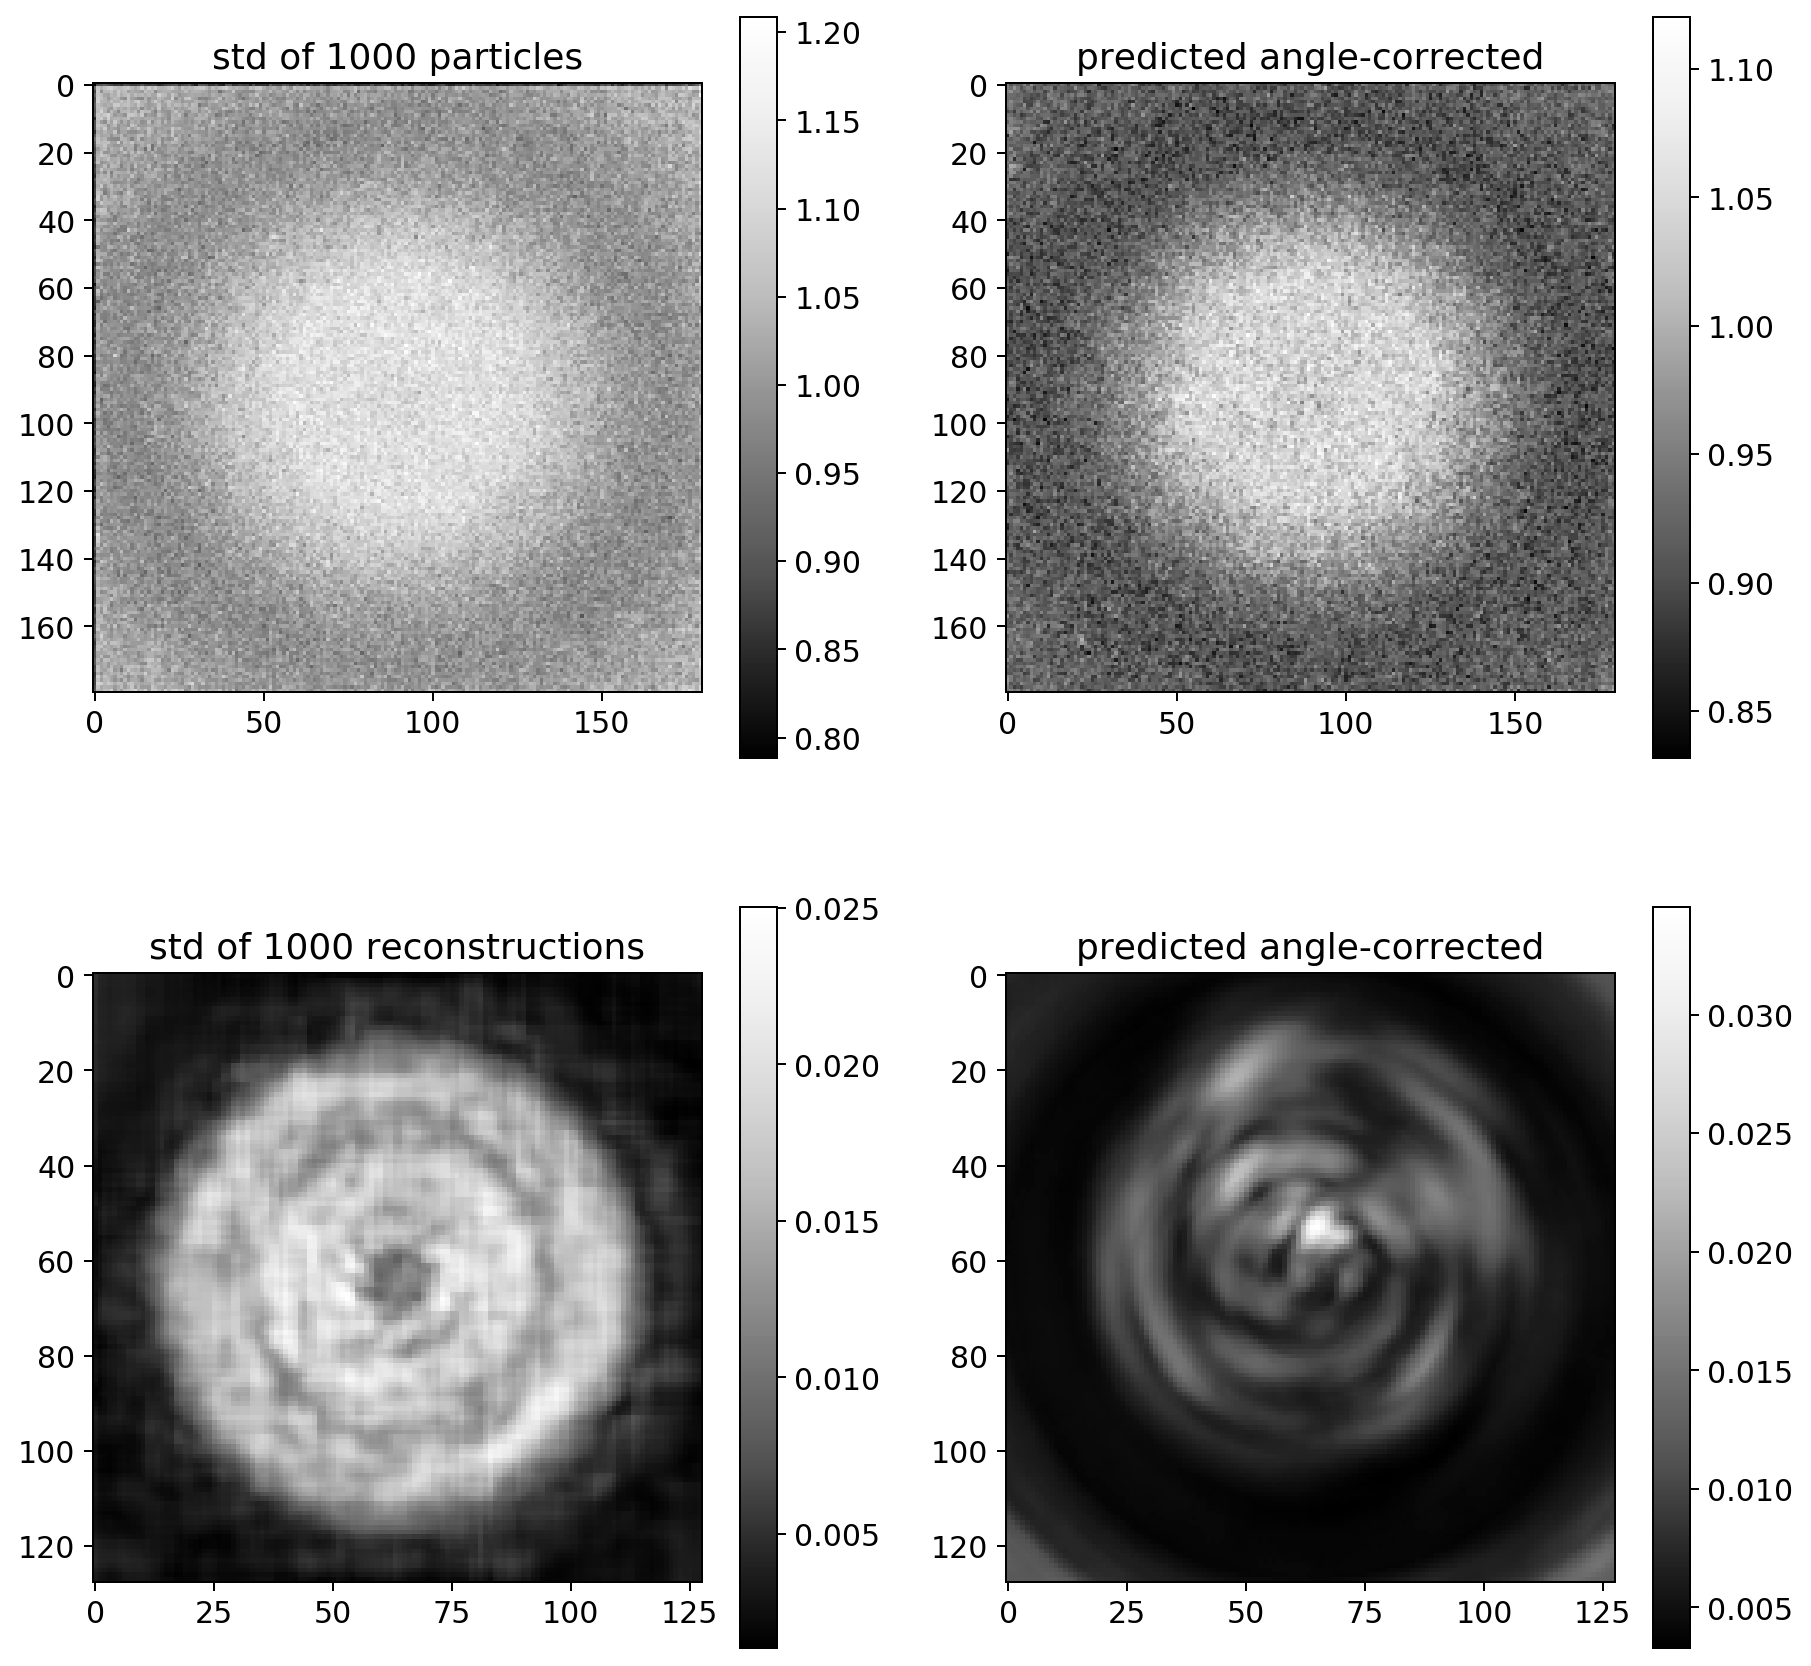

In [45]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('std of 1000 particles')
plt.imshow(np.std(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('predicted angle-corrected')
plt.imshow(np.std(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('std of 1000 reconstructions')
plt.imshow(np.std(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('predicted angle-corrected')
plt.imshow(np.std(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

### need to do translations ?

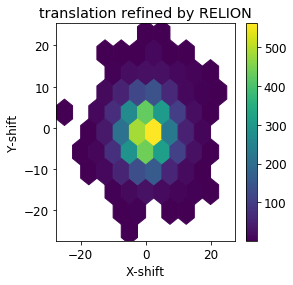

In [71]:
fig = plt.figure(figsize=(4,4))
plt.title('translation refined by RELION')
tx = np.array(metadata['_rlnoriginx'])
plt.xlabel('X-shift')
ty = np.array(metadata['_rlnoriginy'])
plt.ylabel('Y-shift')
plt.hexbin(tx,ty,mincnt=1,gridsize=10)
plt.colorbar()
tx_curated = tx
ty_curated = ty

In [99]:
from scipy.ndimage import rotate, shift
recon_rot = np.zeros(recon.shape)
particles_rot = np.zeros(particles_dataset.shape)
for i in np.arange(1000):
    particle       = particles_dataset[i,0,:,:]
    #reconstruction = recon[i,0,:,:]
    particle_shift = shift(particle, shift=((-tx_curated[i],-ty_curated[i])),mode='wrap')
    recon_shift    = shift(reconstruction, shift=((-tx_curated[i],-ty_curated[i])),mode='wrap')
    recon_rot[i,0,:,:]     = rotate(recon_shift,angle=-angle_curated[i],axes=(0,1),mode='wrap', reshape=False) 
    particles_rot[i,0,:,:] = rotate(particle_shift,angle=-angle_curated[i],axes=(0,1), mode='wrap', reshape=False) 

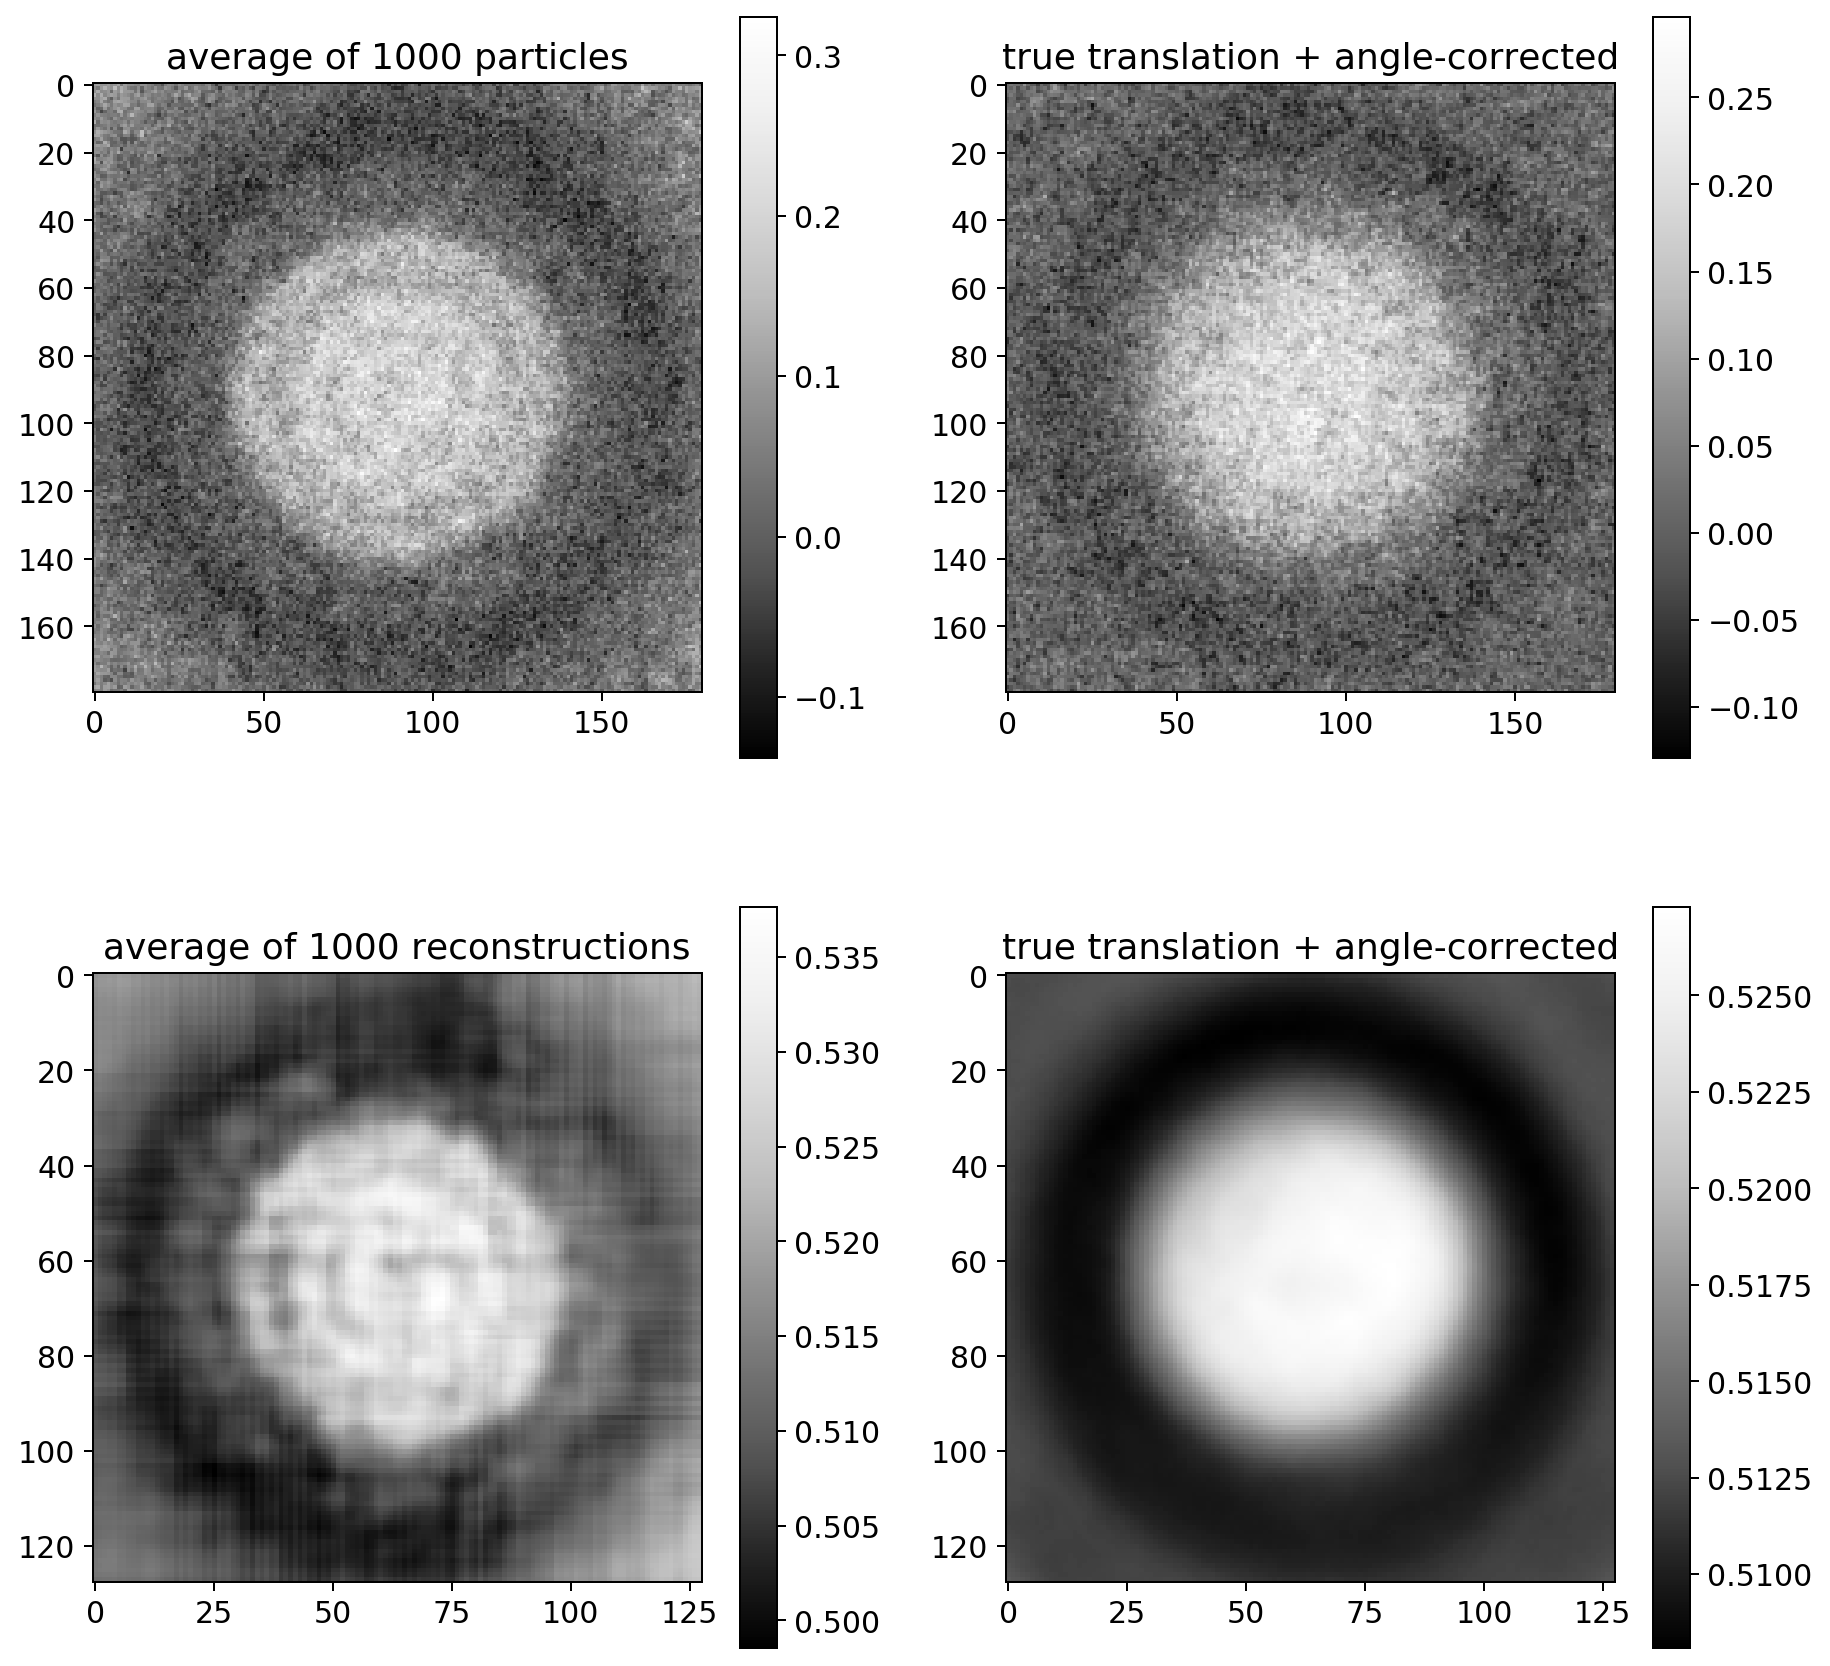

In [101]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true translation + angle-corrected')
plt.imshow(np.mean(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true translation + angle-corrected')
plt.imshow(np.mean(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

## Old stuff

In [ ]:
figname=KEYWORD+'/latent_space_biplot.png'
#
run_cell=False
show_png=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
if run_cell:
    viz.biplots(mus, prj2=mus,
                n=4, nbins=100,
                c=defocus_true,
                c2=angle_true, c2map='twilight',
                show_histo=False,
                figname=figname
               )
Image(figname)

In [ ]:
U, L, Vt = np.linalg.svd(mus - np.mean(mus,axis=0), full_matrices=False)

In [ ]:
figname=KEYWORD+'/latent_space_pca_biplot.png'
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
if run_cell:
    viz.biplots(U, prj2=U,
                n=4, nbins=100,
                c=defocus_true,
                c2=angle_true, c2map='twilight',
                show_histo=False,
                figname=figname
               )
Image(figname)

# Data curation

In [ ]:
# this is juste convenient
fig_force_update=False
if fig_force_update_master:
    fig_force_update=True

## Outlier prediction

In [ ]:
Zscore_set        = 2
measure_threshold = 0.5
methods     = ['robust_covar', 'isolation_forest', 'local_outlier_detection']
method_best = methods[1]

In [ ]:
positives = np.where(Zscore<Zscore_set)[0]
negatives = np.where(Zscore>Zscore_set)[0]
print('True positives: {} | True negatives: {}'.format(positives.shape[0],negatives.shape[0]))

In [ ]:
labels=['Robust Covariance Method', 'Isolation Forest', 'Local Outlier Detection']
fig = plt.figure(figsize=(6,6), dpi=180)
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
for method in methods:
    measure, offset, assignment = pred.outlier_measure(mus, method=method)
    fpr, tpr, thresholds = metrics.roc_curve(np.where(Zscore<Zscore_set,0,1), measure)
    plt.plot(fpr,tpr, lw=3, linestyle='-')
    print('AUC({}) = {} / offset={}'.format(method, metrics.auc(fpr, tpr), offset))
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle=':')
plt.legend(labels, loc=0, fontsize='xx-large')
#plt.legend(methods, loc=0, fontsize='xx-large')
plt.grid()
fig.savefig(KEYWORD+'/ROC_Zscore'+str(Zscore_set))
#

In [ ]:
measure, offset, assignment = pred.outlier_measure(mus, method=method_best)
index_kept = np.where(measure<measure_threshold,0,1)

In [ ]:
plt.hist(measure, bins=20)
plt.show()

In [ ]:
figname=KEYWORD+'/latent_space_{}_biplot.png'.format(method_best)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
run_cell=True
if run_cell:
    viz.biplots(mus, #prj2=U,
                n=4, nbins=100,
                c=measure,
                show_histo=False,
                majortick=2, minortick=1,
                figname=figname
               )
Image(figname)

In [ ]:
figname=KEYWORD+'/latent_space_{}_assigned_t{}_biplot.png'.format(method_best,measure_threshold)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
if run_cell:
    viz.biplots(mus, #prj2=U,
                n=4, nbins=100,
                c=index_kept,
                show_histo=False,
                majortick=0.5,
                figname=figname
               )
Image(figname)

### check out outliers

In [ ]:
mus_outlier     = mus[index_kept==1,:]
defocus_outlier = defocus_true[index_kept==1]
angle_outlier   = angle_true[index_kept==1]
Zscore_outlier  = Zscore[index_kept==1]
print(mus_outlier.shape)

In [ ]:
particles_outlier= np.array(metadata['particles'])[index_kept==1,...]

In [ ]:
particles_outlier.shape

In [ ]:
mus_kept     = mus[index_kept==0,:]
defocus_kept = defocus_true[index_kept==0]
angle_kept   = angle_true[index_kept==0]
Zscore_kept  = Zscore[index_kept==0]
print(mus_kept.shape)

In [ ]:
particles_kept= np.array(metadata['particles'])[index_kept==0,...]
particles_kept.shape

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in np.arange(25):
    plt.subplot(5,5,i+1)
    plt.imshow(particles_outlier[i,...], cmap='Greys_r')

In [ ]:
plt.imshow(np.mean(particles_outlier,axis=0), cmap='Greys_r')

In [ ]:
fig = plt.figure(figsize=(10,10))
i=0
for shift in np.arange(0,400,100):
    i+=1
    plt.subplot(2,2,i)
    plt.imshow(np.mean(particles_kept[shift:particles_outlier.shape[0]+shift,...],axis=0), cmap='Greys_r')
plt.tight_layout()

In [ ]:
from scipy import ndimage
fig = plt.figure(figsize=(10,10))
i=0
for shift in np.arange(0,400,100):
    i+=1
    plt.subplot(2,2,i)
    plt.imshow(
                np.mean(
                  scipy.ndimage.shift(
                      particles_kept[shift:particles_outlier.shape[0]+shift,...],10),axis=0), 
                cmap='Greys_r')
plt.tight_layout()

In [ ]:
from scipy import ndimage
fig = plt.figure(figsize=(10,10))
i=0
for shift in np.arange(0,400,100):
    i+=1
    plt.subplot(2,2,i)
    plt.imshow(
                np.mean(
                  scipy.ndimage.shift(
                      particles_kept[shift:particles_outlier.shape[0]+shift,...],np.random.randint(10,20)),axis=0), 
                cmap='Greys_r')
plt.tight_layout()

In [ ]:
shift = 35
particles_kept_randomshift = np.zeros((particles_outlier.shape))
for i in np.arange(particles_outlier.shape[0]):
    particles_kept_randomshift[i,...] = scipy.ndimage.shift(particles_kept[i,...],
                                                            (np.random.randint(-shift,shift),
                                                            np.random.randint(-shift,shift)))

In [ ]:
plt.imshow(np.mean(particles_kept_randomshift,axis=0), cmap='Greys_r')

In [ ]:
from scipy import ndimage
fig = plt.figure(figsize=(10,10))
i=0
for shift in np.arange(0,400,100):
    i+=1
    plt.subplot(2,2,i)
    plt.imshow(
                np.mean(
                  scipy.ndimage.shift(
                      particles_kept[shift:particles_outlier.shape[0]+shift,...],np.random.randint(-10,10)),axis=0), 
                cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in np.arange(25):
    plt.subplot(5,5,i+1)
    plt.imshow(particles_kept[i,...], cmap='Greys_r')

### back to the flow

## Remove user-defined outliers

In our case, knowledge of metadata helps getting rid of "bad" data (i.e. defocus values out of reasonable range)

In [ ]:
index = np.where((defocus_kept>5000)  & (defocus_kept < 25000))[0]
mus_curated     = mus_kept[index,:]
angle_curated   = angle_kept[index]
defocus_curated = defocus_kept[index]
Zscore_curated  = Zscore_kept[index]
print(mus_curated.shape)

In [27]:
U_curated, L_curated, Vt_curated = np.linalg.svd(mus_curated - np.mean(mus_curated,axis=0), full_matrices=False)

In [ ]:
figname=KEYWORD+'/latent_space_curated_t{}_biplot.png'.format(measure_threshold)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
if run_cell:
    viz.biplots(mus_curated, prj2=mus_curated,
                n=4, nbins=100,
                c=defocus_curated,
                c2=angle_curated, c2map='twilight',
                show_histo=False,
                majortick=0.5,
                figname=figname
               )
Image(figname)

In [ ]:
plt.plot(L_curated, 'Xk')
plt.grid()

In [ ]:
figname=KEYWORD+'/latent_space_pca_scaled_curated_biplot.png'.format(measure_threshold)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
run_cell=True
if run_cell:
    viz.biplots(np.dot(U_curated,np.diag(L_curated)), prj2=np.dot(U_curated,np.diag(L_curated)),
                n=4, nbins=100,
                c=defocus_curated,
                c2=angle_curated, c2map='twilight',
                show_histo=False,
                minortick=np.std(np.dot(U_curated,np.diag(L_curated))[:,0])/2,
                majortick=np.std(np.dot(U_curated,np.diag(L_curated))[:,0]),
                figname=figname,
                colorbar_size=500
               )
Image(figname)

In [ ]:
figname=KEYWORD+'/latent_space_pca_curated_t{}_biplot.png'.format(measure_threshold)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
run_cell=True
if run_cell:
    viz.biplots(U_curated, prj2=U_curated,
                n=4, nbins=100,
                c=defocus_curated,
                c2=angle_curated, c2map='twilight',
                show_histo=False,
                minortick=np.std(U_curated[:,0])/2,
                majortick=np.std(U_curated[:,0]),
                figname=figname,
                colorbar_size=500
               )
Image(figname)

# Parameter prediction with truncated PCA

In [30]:
angle_true   = angle_curated + 180
defocus_true = defocus_curated

In [31]:
U_truncated = U_curated[:,0:3]

## circle prediction

In [35]:
angle_pred, defocus_pred = pred.pred2d(U_truncated, angle_true, defocus_true, 
                                       angle_pred_sign=1.0,
                                       defocus_min=5000,defocus_max=25000,
                                       do_ellipse=False)

In [ ]:
def pred2d_tmp(X,  angle_true, defocus_true,
               angle_pred_sign=1.0,
               defocus_min=0.5,defocus_max=2.5,
               defocus_rescale='minmax',
              do_ellipse=False):
    """
    """
    if do_ellipse:
        center, axis, theta_0, score= fitEllipse(X[:,0:2])
        a       = np.max(axis)
        b       = np.min(axis)
        e       = np.sqrt(1.0 - (b/a)**2)
        rho_centered, theta = cart2sph(X[:,0]-center[0], X[:,1]-center[1])
        rho_ellipse = b/(np.sqrt(1. - (e*np.cos(theta-theta_0))**2))
        rho = rho_centered/rho_ellipse
    else:
        rho, theta = pred.cart2pol(X[:,0], X[:,1])
    #
    angle_pred         = np.mod(angle_pred_sign*(180*theta/np.pi + 180) + 360, 360) 
    #
    rho_normalized = pred.rescale_to_zero_one(rho)
    if(defocus_rescale=='minmax'):
        a = defocus_max - defocus_min
        b = defocus_min
    elif(defocus_rescale=='quartile'):
        Q1_true, Q3_true = np.percentile(defocus_true, [25,75])
        Q1_pred, Q3_pred = np.percentile(rho_normalized, [25,75])
        a = (Q3_true - Q1_true)/(Q3_pred - Q1_pred)
        b = Q1_true - a*Q1_pred
    defocus_predicted  = a*rho_normalized + b
    return angle_pred, defocus_predicted

In [38]:
angle_pred, defocus_pred = pred.pred2d(U_truncated, angle_true, defocus_true, 
                                       angle_pred_sign=-1.0,
                                       defocus_rescale='quartile')

In [ ]:
viz.plot_pred2d(angle_pred, defocus_pred, 
                angle_true, defocus_true, 
                figname=KEYWORD+'/polar_truncated_prediction_circle')

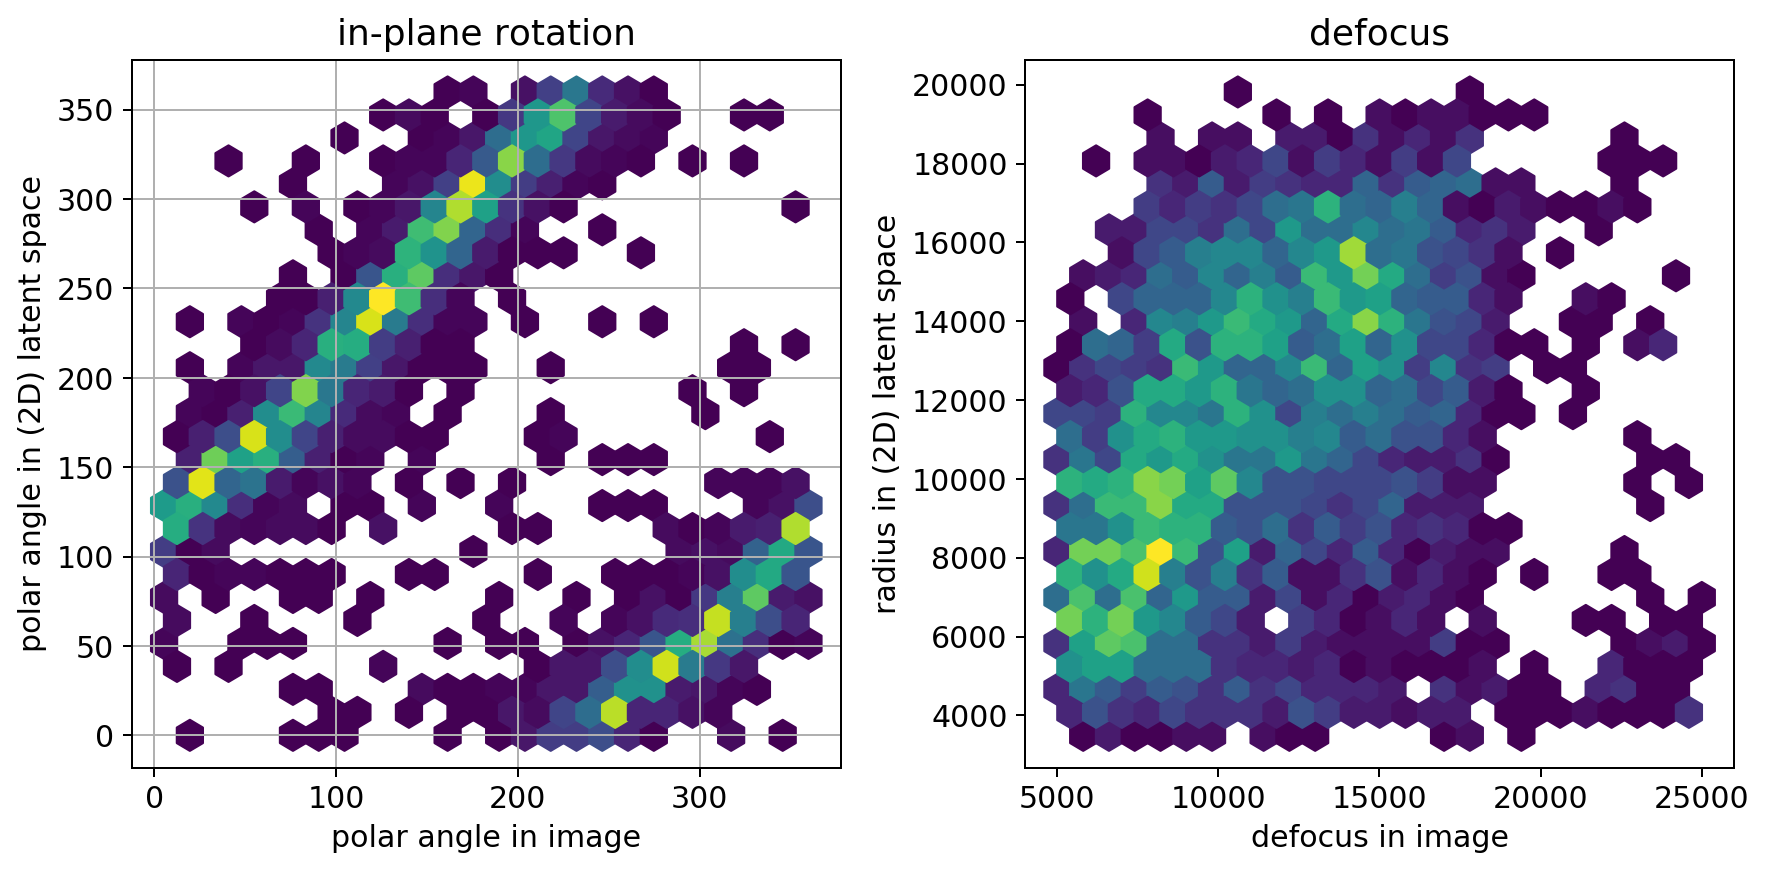

In [39]:
viz.plot_pred2d(angle_pred, defocus_pred, 
                angle_true, defocus_true)#, 
                #figname=KEYWORD+'/polar_truncated_prediction_circle')

In [ ]:
offset_range = np.arange(68,72,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range)
plt.plot(offset_range,angle_RMSE_list)

## weighted circle prediction

In [ ]:
defocus_pred_normalized = pred.rescale_to_zero_one(defocus_pred)

In [ ]:
offset_range = np.arange(65,70,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range,
                                                angle_weight=(np.exp(defocus_pred_normalized)-1), 
                                                norm_weights=True)
plt.plot(offset_range,angle_RMSE_list)

## ellipse prediction

In [ ]:
angle_pred, defocus_pred = pred.pred2d(U_truncated, angle_true, defocus_true, 
                                       angle_pred_sign=1.0,
                                       defocus_min=5000,defocus_max=25000,
                                       do_ellipse=True)

In [ ]:
viz.plot_pred2d(angle_pred, defocus_pred, 
                angle_true, defocus_true, 
                figname=KEYWORD+'/polar_truncated_prediction_ellipse')

In [ ]:
offset_range = np.arange(0,25,2)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range)
plt.plot(offset_range,angle_RMSE_list)

## weighted ellipse prediction

In [ ]:
defocus_pred_normalized = pred.rescale_to_zero_one(defocus_pred)

In [ ]:
offset_range = np.arange(0,25,2)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range,
                                                angle_weight=(np.exp(defocus_pred_normalized)-1), 
                                                norm_weights=True)
plt.plot(offset_range,angle_RMSE_list)

## cone prediction (2D)

*Careful!* We get rid of the first dimension here...

In [ ]:
U_best = pred.rotate_to_fit_cone(U_truncated,10000)

In [ ]:
figname=KEYWORD+'/latent_space_pca_curated_t{}_cone_truncated_rotated_biplot.png'.format(measure_threshold)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
if run_cell:
    viz.biplots(U_best, prj2=U_best,
                n=3, nbins=100,
                c=defocus_curated,
                c2=angle_curated, c2map='twilight',
                show_histo=False,
                minortick=np.std(U_curated[:,0])/2,
                majortick=np.std(U_curated[:,0]),
                figname=figname
               )
Image(figname)

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.hexbin(U_truncated[:,0],np.linalg.norm(U_truncated[:,1:3],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,2)
plt.hexbin(U_truncated[:,1],np.linalg.norm(U_truncated[:,0:3:2],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,3)
plt.hexbin(U_truncated[:,2],np.linalg.norm(U_truncated[:,0:2],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,4)
plt.hexbin(U_best[:,0],np.linalg.norm(U_best[:,1:3],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,5)
plt.hexbin(U_best[:,1],np.linalg.norm(U_best[:,0:3:2],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,6)
plt.hexbin(U_best[:,2],np.linalg.norm(U_best[:,0:2],axis=1), mincnt=1, gridsize=30)

In [ ]:
angle_pred, defocus_pred = pred.pred2d(U_best, angle_true, defocus_true, 
                                       angle_pred_sign=1.0,
                                       defocus_min=5000,defocus_max=25000,
                                       do_ellipse=True)

In [ ]:
viz.plot_pred2d(angle_pred, defocus_pred, 
                angle_true, defocus_true, 
                figname=KEYWORD+'/polar_truncated_prediction_cone')

In [ ]:
offset_range = np.arange(123,126,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range)
plt.plot(offset_range,angle_RMSE_list)

In [ ]:
defocus_pred_normalized = pred.rescale_to_zero_one(defocus_pred)

In [ ]:
offset_range =  np.arange(250,255,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range,
                                                angle_weight=(np.exp(defocus_pred_normalized)-1), norm_weights=True)
plt.plot(offset_range,angle_RMSE_list)

# Parameter prediction with full PCA

## circle prediction

In [ ]:
angle_pred, defocus_pred = pred.pred2d(U_curated, angle_true, defocus_true, 
                                       angle_pred_sign=-1.0,
                                       defocus_min=5000,defocus_max=25000,
                                       do_ellipse=False)

In [ ]:
viz.plot_pred2d(angle_pred, defocus_pred, 
                angle_true, defocus_true, 
                figname=KEYWORD+'/polar_prediction_circle')

In [ ]:
offset_range = np.arange(25,28,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range)
plt.plot(offset_range,angle_RMSE_list)

## weighted circle prediction

In [ ]:
defocus_pred_normalized = pred.rescale_to_zero_one(defocus_pred)

In [ ]:
offset_range = np.arange(52,58,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range,
                                                angle_weight=(np.exp(defocus_pred_normalized)-1), 
                                                norm_weights=True)
plt.plot(offset_range,angle_RMSE_list)

## ellipse prediction

In [ ]:
angle_pred, defocus_pred = pred.pred2d(U_curated, angle_true, defocus_true, 
                                       angle_pred_sign=-1.0,
                                       defocus_min=5000,defocus_max=25000,
                                       do_ellipse=True)

In [ ]:
viz.plot_pred2d(angle_pred, defocus_pred, 
                angle_true, defocus_true, 
                figname=KEYWORD+'/polar_prediction_ellipse')

In [ ]:
offset_range = np.arange(22,26,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range)
plt.plot(offset_range,angle_RMSE_list)

## weighted ellipse prediction

In [ ]:
defocus_pred_normalized = pred.rescale_to_zero_one(defocus_pred)

In [ ]:
offset_range = np.arange(100,104,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range,
                                                angle_weight=(np.exp(defocus_pred_normalized)-1), 
                                                norm_weights=True)
plt.plot(offset_range,angle_RMSE_list)

## cone prediction (2D)

*Careful!* We get rid of the first dimension here...

In [ ]:
U_best = pred.rotate_to_fit_cone_2d(U_curated[:,1:],10000)

In [ ]:
figname=KEYWORD+'/latent_space_pca_curated_t{}_cone_pickdim_rotated_biplot.png'.format(measure_threshold)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
if run_cell:
    viz.biplots(U_best, prj2=U_best,
                n=3, nbins=100,
                c=defocus_curated,
                c2=angle_curated, c2map='twilight',
                show_histo=False,
                minortick=np.std(U_curated[:,0])/2,
                majortick=np.std(U_curated[:,0]),
                figname=figname
               )
Image(figname)

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.hexbin(U_curated[:,0],np.linalg.norm(U_curated[:,1:3],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,2)
plt.hexbin(U_curated[:,1],np.linalg.norm(U_curated[:,0:3:2],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,3)
plt.hexbin(U_curated[:,2],np.linalg.norm(U_curated[:,0:2],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,4)
plt.hexbin(U_best[:,0],np.linalg.norm(U_best[:,1:3],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,5)
plt.hexbin(U_best[:,1],np.linalg.norm(U_best[:,0:3:2],axis=1), mincnt=1, gridsize=30)
plt.subplot(2,3,6)
plt.hexbin(U_best[:,2],np.linalg.norm(U_best[:,0:2],axis=1), mincnt=1, gridsize=30)

In [ ]:
angle_pred, defocus_pred = pred.pred2d(U_best, angle_true, defocus_true, 
                                       angle_pred_sign=1.0,
                                       defocus_min=5000,defocus_max=25000,
                                       do_ellipse=True)

In [ ]:
viz.plot_pred2d(angle_pred, defocus_pred, 
                angle_true, defocus_true, 
                figname=KEYWORD+'/polar_prediction_cone')

In [ ]:
offset_range = np.arange(123,126,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range)
plt.plot(offset_range,angle_RMSE_list)

In [ ]:
defocus_pred_normalized = pred.rescale_to_zero_one(defocus_pred)

In [ ]:
offset_range =  np.arange(250,255,0.25)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_true, defocus_true, 
                                                angle_offset_range=offset_range,
                                                angle_weight=(np.exp(defocus_pred_normalized)-1), norm_weights=True)
plt.plot(offset_range,angle_RMSE_list)

## cone prediction (any dimension)

In [ ]:
U_best = pred.rotate_to_fit_cone(U_curated,10000)

In [ ]:
figname=KEYWORD+'/latent_space_pca_curated_t{}_cone_rotated_biplot.png'.format(measure_threshold)
#
run_cell=False
if os.path.exists(figname):
    if fig_force_update:
        run_cell=True
else:
    run_cell=True
#
run_cell=True
if run_cell:
    viz.biplots(U_best, prj2=U_best,
                n=4, nbins=100,
                c=defocus_curated,
                c2=angle_curated, c2map='twilight',
                show_histo=False,
                minortick=np.std(U_curated[:,0])/2,
                majortick=np.std(U_curated[:,0]),
                figname=figname
               )
Image(figname)

# the end

In [ ]:
def rotate_to_fit_cone(X,ntry):
    dim = X.shape[1]
    score_list = []
    rotmat = np.identity(dim) #np.diag([1,1,1])
    X_rotated = np.dot(rotmat,X.T).T
    dist = pred.rescale_to_zero_one(np.linalg.norm(X_rotated[:,0:dim-1],axis=1))
    popt, pcov = pred.curve_fit(pred.linear_1d, X_rotated[:,dim-1], dist)
    score = np.abs(popt[0])
    #
    score_max  = score
    rotmat_max = rotmat
    ibest = 0
    score_list.append(score)
    #
    print('   current best ({}/{}): {}'.format(ibest,ntry,score_max))
    for i in np.arange(1,ntry):
        rotmat = pred.special_ortho_group.rvs(dim)
        X_rotated = np.dot(rotmat,X.T).T
        dist = pred.rescale_to_zero_one(np.linalg.norm(X_rotated[:,0:dim-1],axis=1))
        popt, pcov = pred.curve_fit(pred.linear_1d, X_rotated[:,dim-1], dist)
        score = np.abs(popt[0])
        if(score > score_max):
            score_max = score
            ibest = i
            rotmat_max = rotmat
            print('   current best ({}/{}): {}'.format(ibest,ntry,score_max))
        score_list.append(score)
    X_best = np.dot(rotmat_max, X.T).T
    fig = plt.figure()
    plt.hist(score_list, bins=np.int(ntry/10))
    plt.show()
    return X_best
